# Analyse numérique et traitement du son.

L'analyse numérique se prête particulièrement bien au traitement du son, soit en synthèse (fabrication d'un son), soit en analyse (manipulation et décomposition de sons d'origines variées). On utilisera principalement des tableaux `Numpy` pour manipuler les données sonores.

## Première partie. Synthèse sonore.

Depuis les débuts de la synthèse sonore (initialement à l'aide d'instruments analogiques), il est d'usage de synthétiser des sons à l'aide de signaux élémentaires dont on contrôle divers paramètres :

  * la fréquence du signal élémentaire qui donne la hauteur de la note (ex. : 440Hz)
  * la forme de la courbe élémentaire (sinusoïdale, carrée, triangulaire, dents de scie, etc.)
  * l'enveloppe du son (qui modifie l'intensité du signal dans le temps)

Plusieurs oscillateurs peuvent être combinés pour obtenir des timbres plus complexes.

![Formes d'onde](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Formes_d%27onde.png/610px-Formes_d%27onde.png)

De nombreux synthétiseurs fonctionnent sur ce principe ; l'un des plus connus a été le [Minimoog](https://fr.wikipedia.org/wiki/Minimoog) en 1970 :

![MiniMOOG](https://upload.wikimedia.org/wikipedia/commons/2/22/Minimoog.JPG)

### Synthèse d'un son élémentaire

Il est d'usage de travailler à une fréquence d'échantillonage de 44100 Hz, ce qui signifie que 44100 données sont nécessaires pour décrire le son sur une seconde. On admettra que cet usage permet de reproduire des sons jusqu'à la fréquence moitié moindre de 22050 Hz ([théorème d'échantillonnage de Nyquist-Shannon](https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_d%27%C3%A9chantillonnage_de_Nyquist-Shannon)).



In [44]:
import time
import numpy as np
import scipy.io.wavfile

mysoundfile="/home/thomas/Bureau/test.wav"
#mysoundfile = r"C:\Users\Emmanuel Chastel\Desktop\test.wav"

# Code permettant d'enregistrer et de jouer un son
try:
    import winsound   # sous Windows
    def play_wav(a, fr=44100):
        scipy.io.wavfile.write(mysoundfile, fr, (32657*a).astype(np.int16))
        winsound.PlaySound(mysoundfile, winsound.SND_FILENAME)
except:
    import subprocess # Sous Linux
    def play_wav(a, fr=44100):
        scipy.io.wavfile.write(mysoundfile, fr, (32657*a).astype(np.int16))
        subprocess.call(["aplay", mysoundfile]) # remplacer par "afplay" pour Mac OS

#### Synthèse d'un bruit simple

La synthèse d'un bruit « blanc » se fait de façon très simple :

In [45]:
import numpy.random

framerate = 44100
dur = 3

data = numpy.random.rand(dur*framerate) - .5

play_wav(data)

#### Synthèse simple à l'aide d'un oscillateur

On commencera par créer un son de 5 secondes jouant la hauteur de référence, la note La à 440 Hz.

In [2]:
framerate = 44100
freq = 440
dur = 3

data = np.array([ np.sin(2.0 * np.pi * freq * t / framerate) for t in range(dur*framerate)])
play_wav(data)

On joue ici trois notes successives : Do, Mi, Sol sur une durée de cinq secondes.

In [20]:
framerate = 44100
def note(freq, dur):
    global framerate
    return np.array([ np.sin(2.0 * np.pi * freq * t / framerate) for t in range(int(dur*framerate))])

data = np.concatenate( (note(261.63, 1), note(329.63, 1), note(392, 1)) )
play_wav(data)

On compare les quatre formes de courbes sur le La de référence (440 Hz). L'ordre retenu sera (courbe sinusoïdale, courbe triangulaire, courbe en dents de scie, courbe carrée).

In [22]:
framerate = 44100
freq = 440
dur = 2

x = np.array( [ freq*t/framerate for t in range(int(dur*framerate)) ] )

# sinusoïdale
data1 = np.sin(2.0 * np.pi * x)
# carrée
# data2 = 2*((data1 >= 0).astype(np.float64)) - 1
data2 = 2-2*np.floor(2*(x-np.floor(x)))-1
# triangle
data3 = (4-4*np.floor(2*(x+.25-np.floor(x+.25)))-2) * ( 2*(x+.75 - np.floor(x+.75))-1 ) -1
# dents de scie
data4 = 2*(x+.5 - np.floor(x+.5))-1

data = np.concatenate( (data1, data3, data4, data2) )
play_wav(data)

#### Création d'une enveloppe de type ADSR

![Enveloppe d'un son](http://upload.wikimedia.org/wikipedia/commons/e/e4/Enveloppe_ADSR.png)

In [2]:
framerate = 44100
freq = 440
dur = 1.5

def enveloppe(mydata, a, d, s, r):
    snd = np.array(mydata)
    t1 = int(np.round(a*framerate))
    t2 = int(np.round(d*framerate))
    t4 = int(np.round(r*framerate))
    t3 = len(snd) - t1 - t2 - t4
    snd[0:t1] *= np.linspace(0,1,t1)
    snd[t1:t1+t2] *= np.linspace(1,s,t2)
    snd[t1+t2:t1+t2+t3] *= s
    snd[-t4:] *= np.linspace(s,0,t4)
    return snd

x = np.array( [ freq*t/framerate for t in range(int(dur*framerate)) ] )
data = np.sin(2.0 * np.pi * x)

play_wav(data)
time.sleep(.5) # pause d'une demi-seconde
play_wav( enveloppe(data,.1,.1,.85,.1) )

#### Création d'un accord (avec utilisation d'enveloppes)

In [3]:
framerate = 44100
freq = 440
dur = 2.5

def note(freq, dur):
    global framerate
    return np.array([ np.sin(2.0 * np.pi * freq * t / framerate) for t in range(int(dur*framerate))])

data  = enveloppe(note(261.63, dur), .15,.15,.85,.15)
data += enveloppe(note(329.63, dur), .15,.15,.85,.15)
data += enveloppe(note(392.00, dur), .15,.15,.85,.15)

# on multiplie par 1/4 pour éviter un écrêtage
play_wav( data*.25 )

#### Un exemple de synthèse additive : une modélisation basique de la clarinette

La synthèse additive est la plus ancienne ; elle est aujourd'hui moins utilisée car elle trouve rapidement ses limites. Elle se contente d'additionner des signaux afin d'enrichir le son. Les signaux additionnés sont fréquemment les harmoniques discrètes du son de base.

Dans l'exemple suivant, on ajoute à la courbe sinusoïdale de base les premières harmoniques impaires (la fréquence de chacun de ces signaux est multipliée par 3, par 5, par 7, etc.) en diminuant un peu l'amplitude de ces signaux secondaires.

In [4]:
framerate = 44100

# Retourne la fréquence de la note n (numérotation MIDI)
def freq(n):
    return 440*2**((n-69)/12)

def note(n,dur):
  x = np.array( [ freq(n)*t/framerate for t in range(int(dur*framerate)) ] )
  data = (np.sin(2*np.pi*x)+0.75*np.sin(3*2*np.pi*x)+0.5*np.sin(5*2*np.pi*x)+0.14*np.sin(7*2*np.pi*x)+
     0.5*np.sin(9*2*np.pi*x)+0.12*np.sin(11*2*np.pi*x)+0.17*np.sin(13*2*np.pi*x))/8
  return data

for n in range(60,73):
  play_wav( enveloppe(note(n,.45),.1,.1,.85,.1) )

### Des sons moins élémentaires

#### Un exemple de synthèse basé sur une modélisation physique : la corde pincée

Le modèle de Karplus-Strong est assez fameux : il modélise le bruit d'une corde pincée autrement que par synthèse additive en s'efforçant plutôt d'imiter les phénomènes physiques en jeu dans les vibrations d'une corde pincée.

In [5]:
import numpy as np
import numpy.random

framerate = 44100
dur = 5.5

nn = int(dur*framerate)
dn = 160 # faire varier 'dn' pour modifier le son
dln=numpy.random.rand(dn)

data = np.zeros(nn)

for k in range(nn):
    z = 0.5*(dln[-1]+dln[-2])
    dln = np.roll(dln,1); dln[0] = z
    data[k] = z

play_wav(data)

## Seconde partie. Analyse d'un son.

On se servira ici d'une [transformation de Fourier discrète](http://fr.wikipedia.org/wiki/Transformation_de_Fourier_discr%C3%A8te). Le schéma ci-dessous donne le résultat de cette transformation pour la fonction sinus (une fois échantillonnée).

![Schéma de la transformation de Fourier discrète](http://upload.wikimedia.org/wikipedia/commons/thumb/5/58/TFD.JPG/800px-TFD.JPG)

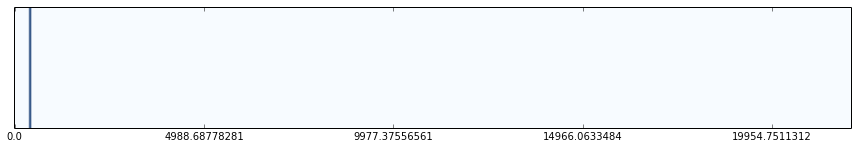

In [8]:
%matplotlib inline

import numpy as np
from numpy.fft import rfft
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.ndimage

framerate = 44100
freq = 440
dur = 2

x = np.array( [ freq*t/framerate for t in range(int(dur*framerate)) ] )

# courbe sinusoïdale
data = np.sin(2.0 * np.pi * x)

# on prend le module
d = rfft(data)
d = abs(d)
# la fréquence x (en Hz) se situe en d[ x * dur ]

# on réduit la taille du tableau (en prenant le maximum au voisinage)
ll = (np.array(range(len(d))) / 100).astype(np.int16)
o = scipy.ndimage.maximum(d, labels=ll, index=list(range(ll[-1]+1)))
o = [o,]*64

# Affichage des fréquences
# ========================

plt.imshow(o,cmap=cm.Blues) # Utilisation d'un dégradé de bleu
plt.gcf().set_size_inches(15,6)
# correction des unités pour l'axe des abscisses
myticks = plt.gca().get_xticks()*framerate/2/len(o[0])
plt.gca().axes.set_xticklabels(myticks)
# suppression des valeurs pour les ordonnées
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

Afin d'améliorer l'affichage des spectres, une fonction spéciale est proposée par l'équipe enseignante du Lycée naval ; elle comporte de nombreuses options.

In [68]:
# Définition d'une fonction élaborée d'affichage des spectres acoustiques

import numpy as np
from numpy.fft import rfft
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.ndimage

def plotSpectrum(data, ax=None,
                 framerate=44100,
                 clipFreq=0,
                 width=640,
                 height=64,
                 cmap = cm.Greys,
                 ticks = 5000,
                 horizontal=True):
  if clipFreq==0 or clipFreq > framerate//2:
    clipFreq = framerate//2
  d = abs(rfft(data))
  l = len(d)
  limit = l*clipFreq*2//framerate
  ll = [ 1 + x*width//limit for x in range(limit) ]
  o = scipy.ndimage.maximum(d[:limit],
        labels=ll, index=list(range(1,1+width)))
  o = [o,]*height
  if not ax: ax = plt.gca()
  if horizontal:
    ax.imshow(o,cmap=cmap)
    ax.axes.get_yaxis().set_visible(False)
    myticks = [ x for x in range(0,clipFreq,ticks) ]
    ax.axes.set_xticks(np.array(myticks)*width//clipFreq)
    ax.axes.set_xticklabels(myticks)
  else:
    ax.imshow(np.array(o).T,cmap=cmap, origin='lower')
    ax.axes.get_xaxis().set_visible(False)
    myticks = [ x for x in range(0,clipFreq,ticks) ]
    ax.axes.set_yticks(np.array(myticks)*width//clipFreq)
    ax.axes.set_yticklabels(myticks)
  return ax

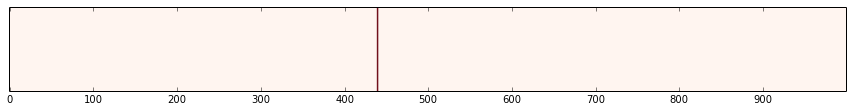

In [72]:
# Test de la fonction

import matplotlib.pyplot as plt
import matplotlib.cm as cm

framerate = 44100
freq = 440
dur = 2

x = np.array( [ freq*t/framerate for t in range(int(dur*framerate)) ] )

# courbe sinusoïdale
data = np.sin(2.0 * np.pi * x)

plotSpectrum(data, clipFreq=1000, ticks=100, cmap=cm.Reds)
plt.gcf().set_size_inches(15,6)
plt.show()

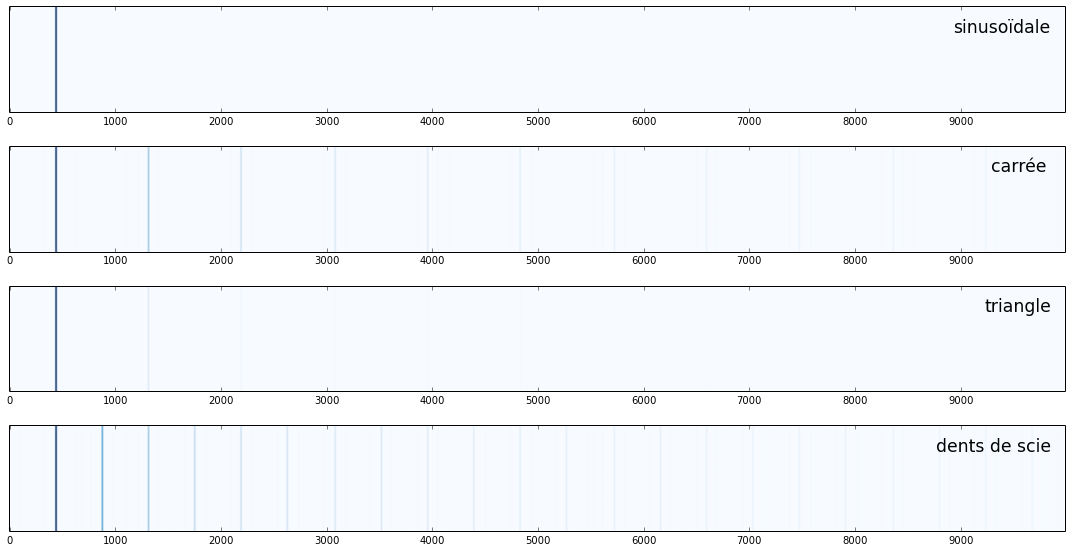

In [94]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# On commence par créer quatre sons correspondant aux quatre courbes

framerate = 44100
freq = 440
dur = 2

x = np.array( [ freq*t/framerate for t in range(int(dur*framerate)) ] )

# sinusoïdale
data1 = np.sin(2.0 * np.pi * x)
# carrée
data2 = 2-2*np.floor(2*(x-np.floor(x)))-1
# triangle
data3 = (4-4*np.floor(2*(x+.25-np.floor(x+.25)))-2) * ( 2*(x+.75 - np.floor(x+.75))-1 ) -1
# dents de scie
data4 = 2*(x+.5 - np.floor(x+.5))-1


# Affichage des fréquences
# ========================

plt.gcf().set_size_inches(15,8)

plt.subplot(4,1,1)
plotSpectrum(data1, ticks=1000, clipFreq=10000, cmap=cm.Blues)
plt.annotate("sinusoïdale",xy=(572,15), size='xx-large')

plt.subplot(4,1,2)
plotSpectrum(data2, ticks=1000, clipFreq=10000, cmap=cm.Blues)
plt.annotate("carrée",xy=(595,15), size='xx-large')

plt.subplot(4,1,3)
plotSpectrum(data3, ticks=1000, clipFreq=10000, cmap=cm.Blues)
plt.annotate("triangle",xy=(591,15), size='xx-large')

plt.subplot(4,1,4)
plotSpectrum(data4, ticks=1000, clipFreq=10000, cmap=cm.Blues)
plt.annotate("dents de scie",xy=(561,15), size='xx-large')

plt.tight_layout()
plt.show()

Noter la présence visible des harmoniques dans les spectres ci-dessus.

#### Analyse d'un morceau de Mozart

On applique une transformée de Fourier sur des petites fenêtres (correspondant à 1/8 sec.) aux premières secondes d'un enregistrement de la sonate en Do majeur.

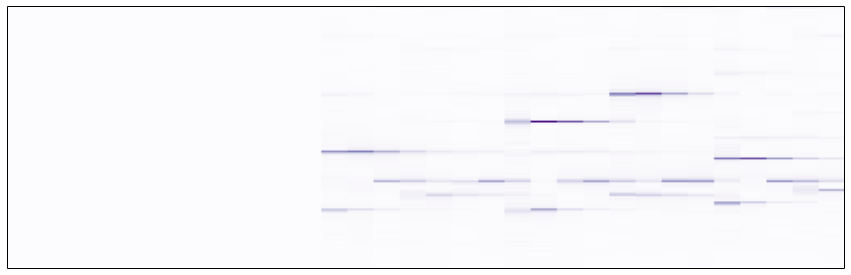

In [19]:
%matplotlib inline

import wave, struct
import numpy as np
from numpy.fft import rfft
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# fichier venant de http://ssl7.ovh.net/~pianoteq/philippe/PIANO/WAV/43mozarts15a.wav
soundfile= '/home/thomas/Bureau/43mozarts15a.wav'
snd = wave.open(soundfile, mode='rb')

framerate = snd.getframerate() # normalement 44100
nchannels = snd.getnchannels() # 2 pour stereo
sw = snd.getsampwidth()        # 2 pour des entiers courts (type 'signed short')

# on lit 4 secondes
data = snd.readframes(4 * nchannels * framerate)
data = struct.unpack_from ("%dh" % 4 * nchannels * framerate, data)
snd.close()

# on garde uniquement le premier canal (gauche)
data = data[::nchannels]

pic = []
# on lit par 1/8 sec.
for i in range(32):
    window = data[i*framerate//8:(i+1)*framerate//8]
    d = abs(rfft(window))
    # on réduit la taille du tableau par troncature (fréquences basses)
    # on recopie la fréquence sur 15 pixels (pour la visibilité)
    o = [d[:150],]*15
    pic += o

# on prend la transposée
pic = np.array(pic).T

# Affichage des fréquences
# ========================

plt.imshow(pic,origin='lower',cmap=cm.Purples) # Utilisation d'un dégradé de violet
plt.gcf().set_size_inches(15,6)
# suppression des valeurs sur les axes
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

Comparer le graphique obtenu avec la première mesure de la partition (et le début de la seconde) :

![Sonate en Do majeur](http://upload.wikimedia.org/wikipedia/commons/b/be/Mozart_k545_opening.png)

(noter les similitudes visuelles évidentes).

Il est bien entendu possible d'utiliser la routine déjà définie pour écouter les premières secondes du morceau :

In [18]:
import wave, struct
import numpy as np

# fichier venant de http://ssl7.ovh.net/~pianoteq/philippe/PIANO/WAV/43mozarts15a.wav
soundfile= '/home/thomas/Bureau/43mozarts15a.wav'
snd = wave.open(soundfile, mode='rb')

framerate = snd.getframerate() # normalement 44100
nchannels = snd.getnchannels() # 2 pour stereo
sw = snd.getsampwidth()        # 2 pour des entiers courts (type 'signed short')

# on lit 12 secondes
data = snd.readframes(12 * nchannels * framerate)
data = struct.unpack_from ("%dh" % 12 * nchannels * framerate, data)
snd.close()

# on garde uniquement le premier canal (gauche)
data = data[::nchannels]

play_wav(np.array(data)/32767)

#### Nettoyage d'un signal bruité

Il arrive que le signal soit très faible ou noyé dans du bruit (détection sous-marine), restauration d'un vieil enregistrement. On propose ici un protocole simple : élimination des fréquences dont la contribution à l'ensemble du signal est trop faible.

In [28]:
# premier exemple : construction d'un signal brouillé

import numpy as np
import numpy.random

framerate = 44100
freq = 440
dur = 3

# note pure
x = np.linspace(0,dur,dur*framerate)
data = np.sin(2*np.pi*freq*x)

data = data/2 + (np.random.rand(len(x)) - .5)

play_wav(data)

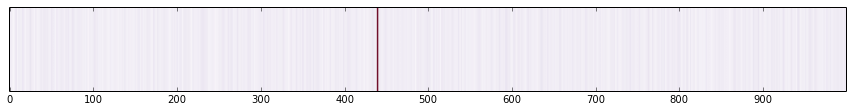

In [101]:
# (suite: exécuter d'abord la cellule précédente)

plotSpectrum(data, ticks=100, clipFreq=1000, cmap=cm.PuRd)
plt.gcf().set_size_inches(15,8)
plt.show()

In [27]:
# (suite: exécuter d'abord les cellules précédentes)
from numpy.fft import rfft, irfft

d = rfft(data)

filtre = abs(d) > 1e3
d2 = d * filtre

data2 = irfft(d2)

play_wav(data2)

Dans l'exemple suivant, le bruit initial est inaudible ; le signal final sera amplifié.

In [97]:
# deuxième exemple : construction d'un signal brouillé

import numpy as np
import numpy.random

framerate = 44100
freq = 440
dur = 3

# note pure
x = np.linspace(0,dur,dur*framerate)
data = np.sin(2*np.pi*freq*x)

data = data/32 + (np.random.rand(len(x)) - .5)

play_wav(data)

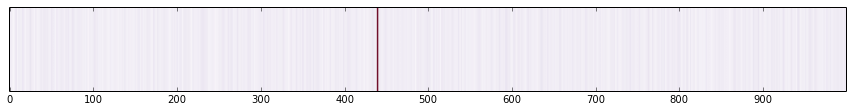

In [100]:
# (suite: exécuter d'abord la cellule précédentes)

plotSpectrum(data, ticks=100, clipFreq=1000, cmap=cm.PuRd)
plt.gcf().set_size_inches(15,8)
plt.show()

In [99]:
# (suite: exécuter d'abord les cellules précédentes)

from numpy.fft import rfft, irfft

d = rfft(data)

filtre = abs(d) > 1e3
d2 = d * filtre

data2 = irfft(d2)

data2 *= 24 # amplification

play_wav(data2)